Approach to the problem that uses transfer learning on existing ResNet network

In [1]:
import numpy as np

import matplotlib.pyplot as plt 

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.nn as nn 
import torch.nn.functional as F

In [2]:
custom_train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224 (for ResNET)
    transforms.ToTensor(),  # Converts image to a PyTorch tensor
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),  # Apply Gaussian blur
    transforms.RandomRotation(degrees=30),  # Apply random rotation (range: -30 to +30 degrees)
])
custom_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224 (for ResNET)
    transforms.ToTensor() # Converts image to a PyTorch tensor
])

In [3]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=custom_train_transform
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=custom_val_transform
)

In [4]:
class Griff_CNN(nn.Module):
    def __init__(self):
        super(Griff_CNN, self).__init__()

        self.model = models.resnet18(weights='DEFAULT')

        # Modify the first convolution layer to accept 1 channel instead of 3
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Replace the last fully connected layer with a new one for 10 classes
        self.model.fc = torch.nn.Linear(in_features=self.model.fc.in_features, out_features=10)

        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        for param in self.model.fc.parameters():
            param.requires_grad = True

    def forward(self, x): 
        
        x = self.model(x)

        return x
                

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model = Griff_CNN().to(device)

Using mps device


In [6]:
def train_loop(dataloader, model, loss_fn, optimizer, history, device):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()

    train_loss, correct_guesses = 0., 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # forward prediction
        pred = model(X) 
        loss = loss_fn(pred, y)
        correct = (pred.argmax(1) == y).type(torch.float).sum().item()

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() 
        correct_guesses += correct 

        if batch % 100 == 0:
            current = batch * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches 
    correct_guesses /= size

    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(correct_guesses)

In [7]:
def test_loop(dataloader, model, loss_fn, history, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0., 0. 

    with torch.no_grad(): 
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X) 
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches 
    correct /= size 
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    history['val_loss'].append(test_loss)
    history['val_accuracy'].append(correct)

In [8]:
loss_fn = nn.CrossEntropyLoss()

batchsize = 64 # mini-batch size 
nworkers = 4
lr = 1.0e-3 # learning rate
epochs = 25 # number of training epochs 

# ADAM optimizer parameters
beta1 = 0.9 
beta2 = 0.999 
eps = 1.0e-8
lambd = 1.0e-5

In [9]:
# Define optimiser
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=lr, 
                             betas=(beta1, beta2), 
                             eps=eps, 
                             weight_decay=lambd)

train_dataloader = DataLoader(training_data, batch_size=batchsize, num_workers=nworkers)
test_dataloader = DataLoader(test_data, batch_size=batchsize, num_workers=nworkers)

In [10]:
history = {'epoch' : [], 
           'train_loss' : [],
           'train_accuracy' : [],
           'val_loss': [],
           'val_accuracy' : []
}

In [11]:

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    history['epoch'].append(t+1)
    train_loop(train_dataloader, model, loss_fn, optimizer, history, device)
    test_loop(test_dataloader, model, loss_fn, history, device)
print("Done!")

Epoch 1
-------------------------------


loss: 2.480666  [    0/60000]
loss: 0.680116  [ 6400/60000]
loss: 0.597371  [12800/60000]
loss: 0.458819  [19200/60000]
loss: 0.428297  [25600/60000]
loss: 0.362912  [32000/60000]
loss: 0.306243  [38400/60000]
loss: 0.292112  [44800/60000]
loss: 0.454297  [51200/60000]
loss: 0.263040  [57600/60000]
Test Error: 
 Accuracy: 93.8%, Avg loss: 0.222216 

Epoch 2
-------------------------------
loss: 0.393486  [    0/60000]
loss: 0.178187  [ 6400/60000]
loss: 0.239043  [12800/60000]
loss: 0.282744  [19200/60000]
loss: 0.213232  [25600/60000]
loss: 0.230421  [32000/60000]
loss: 0.303568  [38400/60000]
loss: 0.256374  [44800/60000]
loss: 0.306615  [51200/60000]
loss: 0.206688  [57600/60000]
Test Error: 
 Accuracy: 94.6%, Avg loss: 0.182674 

Epoch 3
-------------------------------
loss: 0.293801  [    0/60000]
loss: 0.152934  [ 6400/60000]
loss: 0.118398  [12800/60000]
loss: 0.165888  [19200/60000]
loss: 0.158075  [25600/60000]
loss: 0.279769  [32000/60000]
loss: 0.368034  [38400/60000]
loss: 

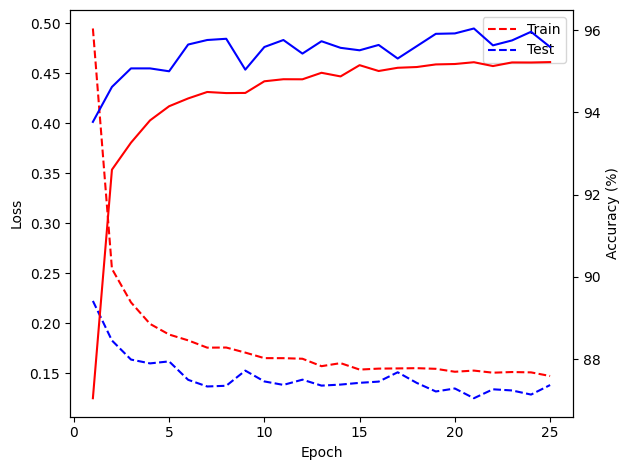

In [12]:
fig, ax = plt.subplots()
ax.plot(history['epoch'], history['train_loss'], color = 'red', linestyle = '--', label = 'Train')
ax.plot(history['epoch'], history['val_loss'], color = 'blue', linestyle = '--', label = "Test")
ax1 = ax.twinx()
ax1.plot(history['epoch'], 100*np.array(history['train_accuracy']), color = 'red', linestyle = '-')
ax1.plot(history['epoch'], 100*np.array(history['val_accuracy']), color = 'blue', linestyle = '-')

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax1.set_ylabel("Accuracy (%)")

ax.legend()

fig.tight_layout()